In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import ast  # For safe evaluation of Python-like strings
from transformers import BertTokenizer
import pickle as pkl
from dataset import RedlistDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import AdamW
from model import RedlistPredictor
from tqdm import tqdm
from transformers import get_scheduler
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
with open("data/data_splits.pkl", "rb") as f:
    data = pkl.load(f)
    unknown_values = pkl.load(f)

df_train = data["train"]
df_test = data["test"]
df_deficient = data["deficient"]

In [3]:
textural_cols = ['rationale', 'habitat', 'threats', 'population', 'range', 'useTrade', 'conservationActions']
for col in textural_cols:
    unknown_values[col] = 'no information'

In [7]:
unknown_values

{'populationTrend': 1.5563551401869158,
 'realm_vector': array([0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'systems_vector': array([0, 0, 0]),
 'possiblyExtinct': 0.007937918369764825,
 'possiblyExtinctInTheWild': 0.00017771459036786921,
 'rationale': 'no information',
 'habitat': 'no information',
 'threats': 'no information',
 'population': 'no information',
 'range': 'no information',
 'useTrade': 'no information',
 'conservationActions': 'no information'}

In [14]:
fractions = {}

for col in unknown_values.keys():
    fracs = []
    for df_split in [df_train, df_test, df_deficient]:
        if col in textural_cols:
            # Compare strings
            match_fraction = df_split[col].str.lower().apply(lambda x: x == '' or any(substring in x for substring in ['no information', 'unknown', 'not known'])).mean()
        elif col in ['populationTrend', 'possiblyExtinct', 'possiblyExtinctInTheWild']:
            # Compare floats with 1e-5 tolerance
            match_fraction = (abs(df_split[col] - unknown_values[col]) < 1e-5).mean()
        else:
            # Compare numpy arrays
            match_fraction = df_split[col].apply(lambda x: np.array_equal(x, unknown_values[col])).mean()
        fracs.append(match_fraction)
    
    fractions[col] = fracs

fractions

{'populationTrend': [0.5044352105619898,
  0.5041254125412541,
  0.9539176139836206],
 'realm_vector': [0.20478590162968202,
  0.20297029702970298,
  0.2679379049016013],
 'systems_vector': [0.0, 0.0, 0.0],
 'possiblyExtinct': [0.0, 0.0, 0.0],
 'possiblyExtinctInTheWild': [0.0, 0.0, 0.0],
 'rationale': [0.054460259923967816, 0.05315888731730316, 0.2147659210365481],
 'habitat': [0.06468629357852239, 0.0627062706270627, 0.1376359858208043],
 'threats': [0.09651371820941267, 0.09806694955209806, 0.5358758098032026],
 'population': [0.20463855244157605, 0.20238095238095238, 0.40129568512406794],
 'range': [0.025520879379954616, 0.0276991984912777, 0.06331744285539664],
 'useTrade': [0.2488433088733681, 0.25377180575200375, 0.31780955873365113],
 'conservationActions': [0.08118940264639142,
  0.0752003771805752,
  0.15902701381249237]}

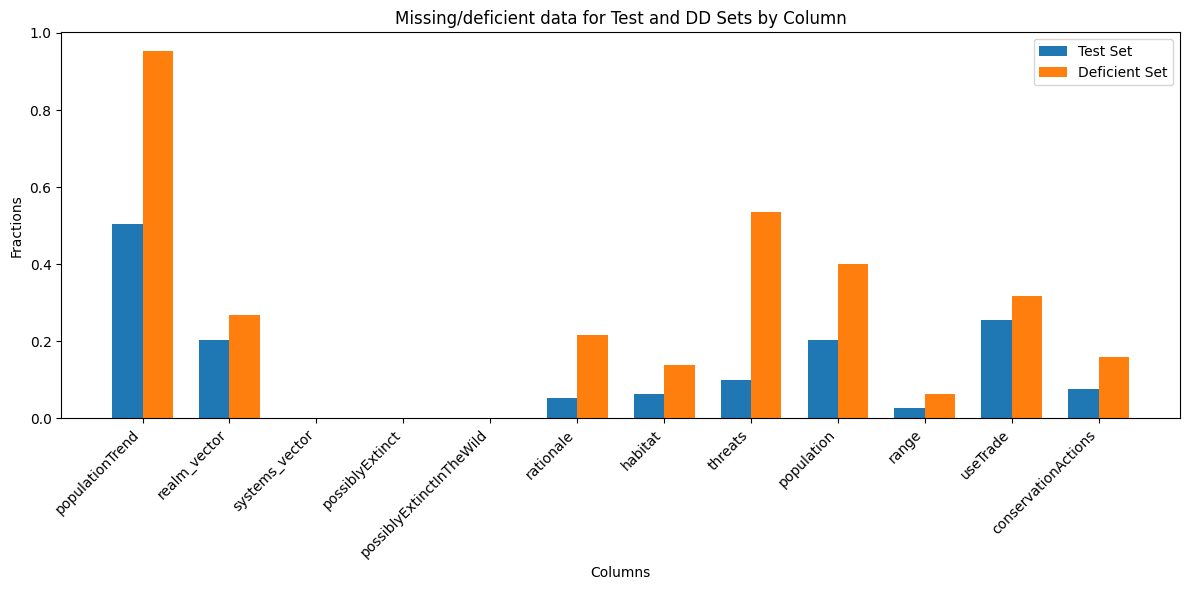

In [15]:
# Extract column names and corresponding fractions for test and deficient sets
columns = list(fractions.keys())
test_fracs = [fractions[col][1] for col in columns]
deficient_fracs = [fractions[col][2] for col in columns]

# Create a bar plot
x = np.arange(len(columns))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, test_fracs, width, label='Test Set')
rects2 = ax.bar(x + width/2, deficient_fracs, width, label='Deficient Set')

# Add labels, title, and legend
ax.set_xlabel('Columns')
ax.set_ylabel('Fractions')
ax.set_title('Missing/deficient data for Test and DD Sets by Column')
ax.set_xticks(x)
ax.set_xticklabels(columns, rotation=45, ha='right')
# ax.set_yscale('log')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# df_pseudoDD = df_test.copy()

In [8]:
frac_gaps = {col: fractions[col][2] - fractions[col][1] for col in fractions if fractions[col][2] - fractions[col][1] > 0}
frac_gaps

{'populationTrend': 0.44979220144236653,
 'realm_vector': 0.06496760787189831,
 'rationale': 0.16160703371924495,
 'habitat': 0.0749297151937416,
 'threats': 0.43780886025110455,
 'population': 0.19891473274311555,
 'range': 0.035618244364118944,
 'useTrade': 0.06403775298164738,
 'conservationActions': 0.08382663663191717}

In [9]:
df_pseudoDD

,assessmentId,scientificName,internalTaxonId,redlistCategory,rationale,habitat,threats,population,range,useTrade,...,className,orderName,familyName,genusName,className_idx,orderName_idx,familyName_idx,genusName_idx,structured_vector,text_input
3546,2224387,Ostorhinchus melanoproctus,193338,1,"this widely distributed, reef species is reaso...","this species forms aggregations in clear, coas...",this species is a component of the marine orna...,"this species is relatively common, though seld...",this species is distributed in the west pacifi...,this species is a component of the marine orna...,...,ACTINOPTERYGII,PERCIFORMES,APOGONIDAE,Ostorhinchus,2,4,40,59,"[1.5563551401869158, 0.0, 0.0, 0.0, 0.0, 0.0, ...","this widely distributed, reef species is reaso..."
39384,137454416,Bidenichthys paxtoni,135439767,1,this rocky-reef species is known from three sp...,this benthopelagic species inhabits crevices i...,there are no known major threats.,population data are limited. this species is o...,this species is only known from three localiti...,this species is not utilized.,...,ACTINOPTERYGII,OPHIDIIFORMES,BYTHITIDAE,Bidenichthys,2,42,240,6750,"[1.5563551401869158, 0.0, 0.0, 0.0, 0.0, 0.0, ...",this rocky-reef species is known from three sp...
17182,22294411,Crocidura denti,40626,1,listed as [REDACTED] in view of its wide distr...,this species is found in subtropical and tropi...,there appear to be no major threats as a whole...,there is no population information available f...,crocidura denti has a disjunct distribution in...,,...,MAMMALIA,EULIPOTYPHLA,SORICIDAE,Crocidura,3,90,621,3945,"[1.5563551401869158, 0.0, 0.0, 0.0, 0.0, 0.0, ...",listed as [REDACTED] in view of its wide distr...
46616,177179239,Hyla hallowellii,55499,1,although its extent of occurrence (eoo) is onl...,"this species occurs in wet areas, including ri...",there are no known significant threats to this...,it is a common species. although there are som...,this species occurs in the ryukyu archipelago ...,individuals of this species taken from the wil...,...,AMPHIBIA,ANURA,HYLIDAE,Hyla,4,9,19,5125,"[2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",although its extent of occurrence (eoo) is onl...
47376,191708662,Cebus olivaceus,81384371,1,cebus olivaceus is considered [REDACTED] (lc)....,cebus olivaceus is found in primary forest.,"habitat loss is the principal threat, but ther...",populations are suspected to be stable (suspec...,"cebus olivaceus schomburgk, 1848 – is found in...",there is minimal evidence of hunting threat.,...,MAMMALIA,PRIMATES,CEBIDAE,Cebus,3,75,511,3184,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cebus olivaceus is considered [REDACTED] (lc)....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48851,212824726,Pseudogastromyzon laticeps,212824724,2,this species occupies a moderately small range...,this is a small benthic species that dwells in...,this species' habitat is impacted by habitat d...,the species is considered to be common but slo...,this species occurs across several small coast...,this species is popular in aquariums due to it...,...,ACTINOPTERYGII,CYPRINIFORMES,GASTROMYZONTIDAE,Pseudogastromyzon,2,14,84,527,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",this species occupies a moderately small range...
43408,161572338,Eleutherodactylus neiba,82410208,4,listed as [REDACTED] because its extent of occ...,this species inhabits mesic humid forests and ...,the cloud forest habitat of this species is be...,it is locally common and appears to be more co...,this species is known only from two areas in t...,there are no records of this species being uti...,...,AMPHIBIA,ANURA,ELEUTHERODACTYLIDAE,Eleutherodactylus,4,9,263,1339,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",listed as [REDACTED] because its extent of occ...
24518,67608959,Anolis bonairensis,67608716,3,listed as [REDACTED] on the basis that this sp...,this species is abundant in good-quality dry t...,"the las aves archipelag

In [10]:
df_pseudoDD.loc[0, 'populationTrend']

1.0

In [11]:
unknown_values['realm_vector']

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

In [12]:
df_pseudoDD.loc[20264, 'realm_vector']

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

In [13]:
print(df_pseudoDD['realm_vector'].dtype)


object


In [14]:
import random

for col, gap in frac_gaps.items():
    # Calculate the number of rows to sample based on the fraction
    num_rows_to_sample = int(len(df_pseudoDD) * gap)
    
    # Randomly sample the indices of the rows to modify
    sampled_indices = random.sample(df_pseudoDD.index.tolist(), num_rows_to_sample)
    print(sampled_indices)
    
    # Update the sampled rows with the unknown value for the column
    for idx in sampled_indices:

        try:
            df_pseudoDD.at[idx, col] = unknown_values[col]
        except Exception as e:
            print("idx:", idx, "type:", type(idx))
            print("len(idx):", len(idx))
            print("unknown_values[col] shape:", unknown_values[col].shape)

            assert len(df_pseudoDD.loc[idx, col]) == len(unknown_values[col])
            raise e

[5727, 4329, 40115, 19217, 27416, 46919, 34453, 3236, 10515, 35337, 23462, 4167, 34540, 43038, 30297, 9158, 28728, 49266, 38223, 18557, 16168, 15336, 24754, 8429, 44442, 703, 49936, 43042, 24106, 45515, 47977, 6023, 3402, 13871, 5688, 36234, 40879, 18645, 14944, 23450, 11401, 10226, 5607, 31684, 3218, 46625, 10665, 8734, 17524, 30370, 15611, 19420, 3036, 47946, 42617, 43643, 47150, 18945, 31226, 20542, 46986, 41443, 9857, 48929, 15152, 30664, 34636, 10395, 12786, 44447, 40059, 11776, 13563, 45848, 7160, 251, 28840, 26405, 27443, 28213, 38108, 16753, 13603, 9256, 34577, 20488, 4372, 15855, 38746, 13186, 37792, 1818, 47755, 37934, 37621, 13139, 27269, 37735, 17716, 13059, 44910, 46531, 38519, 4176, 668, 40913, 22675, 49053, 15146, 8675, 12753, 32469, 41119, 12945, 17489, 48656, 27465, 42987, 37171, 25145, 16464, 42065, 12291, 16118, 32755, 39206, 15933, 35315, 19238, 50168, 46484, 48926, 12957, 2888, 4792, 35988, 5503, 12333, 8899, 48994, 12601, 49937, 8344, 34922, 3831, 16993, 36836, 25

In [55]:
# Filter rows where the condition is not true
filtered_rows = df_pseudoDD[abs(df_pseudoDD['populationTrend'] - unknown_values['populationTrend']) > 1e-5]

print(len(filtered_rows)/len(df_pseudoDD))

0.2123998114097124


In [57]:
(abs(df_pseudoDD['populationTrend'] - unknown_values['populationTrend']) < 1e-5).mean()

0.7876001885902876

In [58]:
# Calculate the number of rows to sample
num_rows_to_sample = int(len(df_pseudoDD) * (0.954 - 0.79))

# Randomly sample the required number of rows
sampled_indices = filtered_rows.sample(num_rows_to_sample).index

# Update the 'populationTrend' column for the sampled rows
for idx in sampled_indices:
    df_pseudoDD.at[idx, 'populationTrend'] = unknown_values['populationTrend']

In [ ]:
# fractions = {}

# for col in unknown_values.keys():
#     fracs = []
#     for df_split in [df_train, df_pseudoDD, df_deficient]:
#         if col in textural_cols:
#             # Compare strings
#             # match_fraction = len(df_split[df_split[col]==unknown_values[col]]) / len(df_split)
#             match_fraction = df_split[col].str.lower().apply(lambda x: x == 'no information' or any(substring in x for substring in ['no information', 'unknown', 'not known'])).mean()
#         elif col in ['populationTrend', 'possiblyExtinct', 'possiblyExtinctInTheWild']:
#             # Compare floats with 1e-5 tolerance
#             match_fraction = (abs(df_split[col] - unknown_values[col]) < 1e-5).mean()
#         else:
#             # Compare numpy arrays
#             match_fraction = df_split[col].apply(lambda x: np.array_equal(x, unknown_values[col])).mean()
#         fracs.append(match_fraction)
    
#     fractions[col] = fracs

# fractions

In [4]:
with open("data/pseudoDD", "rb") as f:
    df_pseudoDD = pkl.load(f)
    pseo_preds = pkl.load(f)

In [6]:
df_pseudoDD['tax_text'] = df_pseudoDD.apply(
    lambda row: f"Class: {row['className']}, Order: {row['orderName']}, Family: {row['familyName']}, Genus: {row['genusName']}, species: {row['scientificName']}",
    axis=1
)

In [7]:
fractions = {}

for col in unknown_values.keys():
    fracs = []
    for df_split in [df_train, df_pseudoDD, df_deficient]:
        if col in textural_cols:
            # Compare strings
            # match_fraction = len(df_split[df_split[col]==unknown_values[col]]) / len(df_split)
            match_fraction = df_split[col].str.lower().apply(lambda x: x == 'no information' or any(substring in x for substring in ['no information', 'unknown', 'not known'])).mean()
        elif col in ['populationTrend', 'possiblyExtinct', 'possiblyExtinctInTheWild']:
            # Compare floats with 1e-5 tolerance
            match_fraction = (abs(df_split[col] - unknown_values[col]) < 1e-5).mean()
        else:
            # Compare numpy arrays
            match_fraction = df_split[col].apply(lambda x: np.array_equal(x, unknown_values[col])).mean()
        fracs.append(match_fraction)
    
    fractions[col] = fracs

fractions

{'populationTrend': [0.5044352105619898,
  0.9515558698727016,
  0.9539176139836206],
 'realm_vector': [0.20478590162968202,
  0.23715228665723714,
  0.2679379049016013],
 'systems_vector': [0.0, 0.0, 0.0],
 'possiblyExtinct': [0.0, 0.0, 0.0],
 'possiblyExtinctInTheWild': [0.0, 0.0, 0.0],
 'rationale': [0.05275100934193853, 0.20462046204620463, 0.21329910768854662],
 'habitat': [0.0634780302360534, 0.132013201320132, 0.13629140691846964],
 'threats': [0.09433295022544426, 0.49222065063649223, 0.5344089964552011],
 'population': [0.20245778445760765, 0.3609146628948609, 0.3995844028847329],
 'range': [0.02410632717413727, 0.061291843470061294, 0.061850629507395186],
 'useTrade': [0.07856658709810509, 0.1379066478076379, 0.11758953673145092],
 'conservationActions': [0.07818347920902956,
  0.14933993399339934,
  0.15633785600782302]}

In [62]:
# Compare the two DataFrames column by column and count the number of differing cells
# num_differing_cells = 0

# for col in df_test.columns:
# 	if df_test[col].dtype == 'object':  # Handle object columns
# 		num_differing_cells += (df_test[col].apply(str) != df_pseudoDD[col].apply(str)).sum()
# 	elif df_test[col].dtype == 'float64' or df_test[col].dtype == 'int64':  # Handle numeric columns
# 		num_differing_cells += (df_test[col] != df_pseudoDD[col]).sum()
# 	else:  # Handle array-like columns
# 		num_differing_cells += df_test[col].apply(lambda x: not np.array_equal(x, df_pseudoDD.loc[x.name, col])).sum()

# print(f"Number of differing cells: {num_differing_cells}")

Number of differing cells: 21485


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RedlistPredictor(
    bert_model_name='bert-base-uncased',
    structured_input_dim=len(df_train.iloc[0]['structured_vector']),
    hidden_dim=256,
    num_classes=6
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [15]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    print('-- begin evaluation')

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tax_input_ids = batch['tax_input_ids'].to(device)
            tax_attention_mask = batch['tax_attention_mask'].to(device)
            structured_input = batch['structured_input'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask, tax_input_ids, tax_attention_mask, structured_input)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print('-- Evaluation results:')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Loss: {avg_loss:.4f}")

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }, all_preds

In [11]:
checkpoint_path = f"checkpoints_main/checkpoint_epoch_6.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RedlistPredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
test_res, test_preds = evaluate(model, test_loader, criterion)

In [12]:
import re
def parse_vector_string(v):
    # Handles strings like "[1 0 0]" → array([1, 0, 0])
    return np.array([int(i) for i in v.strip('[]').split()], dtype=np.int32)

# Load CSV
# df = pd.read_csv("data/df_processed.csv")  # replace with actual path

# Parse vectors
# df['realm_vector'] = df['realm_vector'].apply(parse_vector_string)
# df['systems_vector'] = df['systems_vector'].apply(parse_vector_string)

# Combine structured features into one array
df_pseudoDD['structured_vector'] = df_pseudoDD.apply(
    lambda row: np.concatenate([
        np.array([row['populationTrend']]), 
        np.array([row['possiblyExtinct']]), 
        np.array([row['possiblyExtinctInTheWild']]), 
        row['realm_vector'], 
        row['systems_vector']
    ]),
    axis=1
)

strings_to_delete = set(['(lc)', '(nt)', '(vu)', '(en)', '(cr)', '(ex)'])
df_pseudoDD['rationale'] = df_pseudoDD['rationale'].replace(
    to_replace=r'|'.join(re.escape(s) for s in strings_to_delete),
    value='',
    regex=True
)

text_cols = ['rationale', 'habitat', 'threats', 'population', 'range', 'useTrade', 'conservationActions']
df_pseudoDD['text_input'] = df_pseudoDD[text_cols].fillna("No information").agg(" [SEP] ".join, axis=1)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = RedlistDataset(df_train, tokenizer)
test_dataset = RedlistDataset(df_test, tokenizer)
pseodoDD_dataset = RedlistDataset(df_pseudoDD, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
pseodoDD_loader = DataLoader(pseodoDD_dataset, batch_size=16)

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
pseodo_res, pseo_preds = evaluate(model, pseodoDD_loader, criterion)

-- begin evaluation
-- Evaluation results:
Accuracy: 0.9338
Precision: 0.8536
Recall: 0.8554
F1 Score: 0.8536
Loss: 0.2442


In [16]:
label_to_category = {
    0: 'Least Concern',
    1: 'Near Threatened',
    2: 'Vulnerable',
    3: 'Endangered',
    4: 'Critically Endangered',
    5: 'Extinct'
}

In [17]:
class_labels = [f'{id}: {label_to_category[id]}' for id in range(6)]

def plot_confusion_matrix(true_labels, predicted_labels, is_normalized, title_str=''):
    
    if is_normalized:
        cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    else:
        cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues", xticklabels=range(6), yticklabels=class_labels)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    if is_normalized:
        plt.title("Confusion Matrix (Normalized)"+title_str)
    else:
        plt.title("Confusion Matrix (Raw Counts)"+title_str)
    plt.show()

In [19]:
test_true_labels = [sample['label'] for sample in test_dataset]

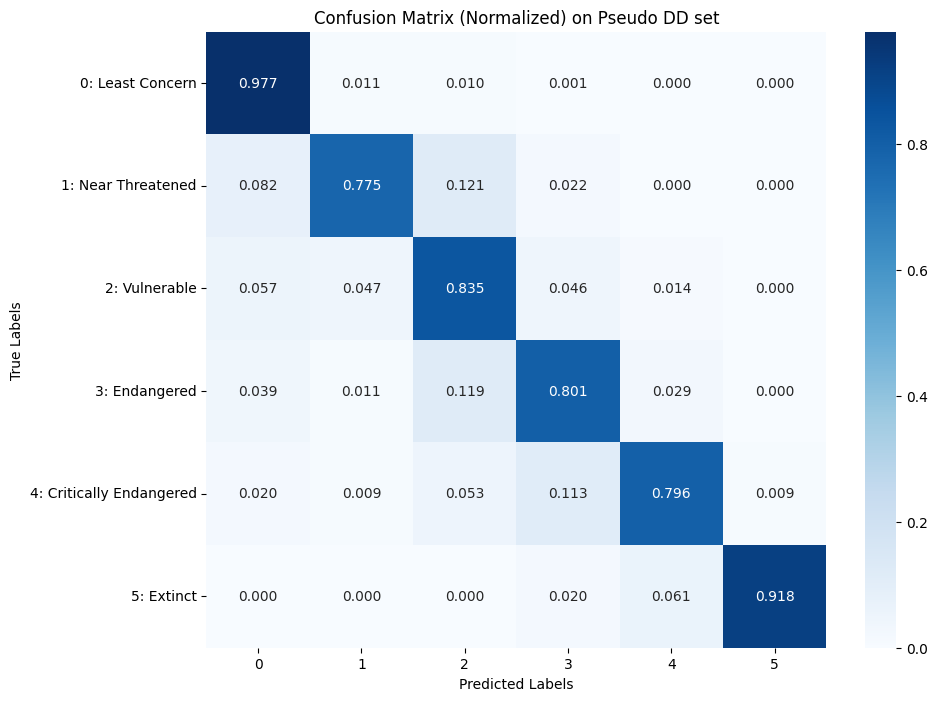

In [20]:
plot_confusion_matrix(test_true_labels, pseo_preds, is_normalized=True, title_str=' on Pseudo DD set')

In [70]:
with open('data/pseudoDD', 'wb') as f:
    pkl.dump(df_pseudoDD, f)
    pkl.dump(pseo_preds, f)
    